In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from time import time
from joblib import Memory
from joblib import parallel_backend
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import tempfile
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg
import os
import pywt
from util import IndexTracker
from util import par_feat_extract
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
rextract = 0
# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
            
    voxel_size = seg.header['pixdim'][0:3]
    voxel_sizes.append(voxel_size)
    segs.append(seg.get_fdata())

    qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
    qsms.append(qsm.get_fdata())
    
    case_list.append(filename)
    n_cases = len(segs)

label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
label_max = np.amax(seg.get_fdata())

F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 01
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 02
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 03
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 04
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 05
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 06
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 07
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 08
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 09
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 10
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 11
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 12
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 13
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 14
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 15
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 16
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 17
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 18
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 19
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 20


In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('Phi_rr', 'wb') as fp:  
        pickle.dump(Phi, fp)


In [5]:
with open('Phi_rr', "rb") as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [7]:
 # SAS features 
pre_sas = np.array((8,2,12,17,11,22,2,5,13,4,11,7,7,16,9,8,9,13,10,11,6,5,17,12,11,21,9)).T
post_sas = np.array((21,3,19,13,13,14,11,12,23,12,4,6,11,28,17,8,21,8,17,11,9,20,17,19,15,19,11)).T
per_change = (post_sas-pre_sas)/pre_sas
# Apathy features
ap = np.array(('Y','N','Y','Y','Y','Y','N','Y','Y','Y','Y','Y','N','Y','Y','N','Y','Y','Y','Y','N','N','Y','N','Y','N','N')).T
ap[ap=='Y'] = 1 
ap[ap=='N'] = 0
bi_sas = ap

In [40]:
case_id = np.repeat(np.arange(1,n_cases+1),2)
for j in range(1,n_cases):
    # Extract numeric feature values
    n_ROIs = 2
    x_row = []
    x_row_t = []
    keys = []
    per_change_train = []
    for i in range(Phi.__len__()):
        # if case_id[i] != case_id[j]:
            featureVector = Phi[i]
            for key, value in six.iteritems(featureVector):
                if 'diagnostic' in key:
                    next
                else:
                    x_row.append(value)
                    keys.append(key)
            x_row.append(pre_sas[case_id[i]-1])
            x_row.append(post_sas[case_id[i]-1])
            x_row.append(bi_sas[case_id[i]-1])
            keys.append('pre_sas')
            keys.append('post_sas')
            keys.append('binary_sas')
            if np.mod(i,2):
                per_change_train.append(per_change[case_id[i]-1])

    X0 = np.array(x_row)
    X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
    X0_t = X[j,:]
    np.delete(X,j,0)
    # Normalize testing and training cases together
    #   Set with_mean=False to preserve data sparsity
    #   And with_std=False 
    #   However, need a significant number of samples to do this
    scaler = StandardScaler()
    X_all = np.vstack((X,X0_t))
    X_all_t = scaler.fit_transform(X_all)
    X_t = X_all_t[X.shape[0]:,:]
    X = X_all_t[:X.shape[0]]
    # Cross-validation for model selection
    cv = KFold(n_cases-4)
    # Identify most important features
    clf = LassoCV(fit_intercept=True,cv=cv,max_iter=10000,alphas=((1e-3,1e-2,1e-1,1e1,10e1,10e2,10e3))).fit(X,per_change_train)
    # Feature selection
    sfm = SelectFromModel(clf,max_features=100,importance_getter=clf.coef_)
    # Initialize pipeline
    clf_in = Pipeline([('LassoSelect',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))])
    # Select the optimal number of clusters with grid search
    Cs = ((1e-1,5e-1,1,10,100))
    epsilons = ((0.25,0.5,0.75))
    clf_nsvr = GridSearchCV(clf_in,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error')
    clf_nsvr.fit(X,per_change_train)
    ut = clf_nsvr.best_estimator_.predict(X_t)
    print('Predicted percentage change of',ut,'for case',j)
    print('True percentage change',per_change_train[j])
    print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))



In [19]:
feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
for k in range(feats.__len__()-1):
    if feats[k] == True:
        print(keys[feats[k]])



False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
original_shape_Elongation
False
or

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


In [11]:
keys

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original

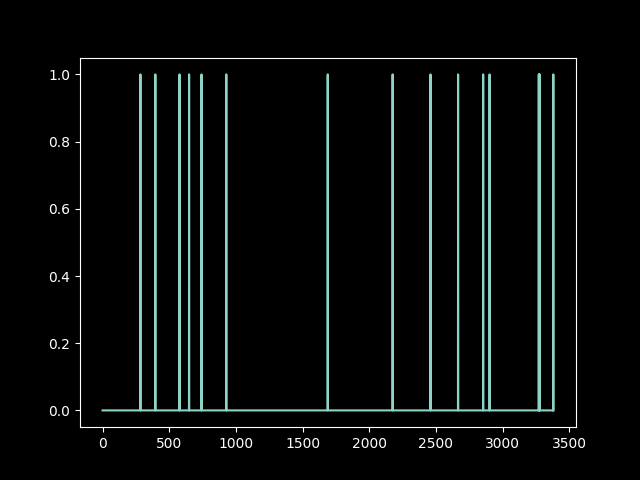

In [12]:
fig,ax = plt.subplots(1,1)
plt.plot(feats)
plt.show()

In [13]:
clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape

(18, 17)

In [14]:
np.array(clf_nsvr.best_estimator_.predict(X))

array([0.62541046, 0.37461877, 0.41753156, 0.21314088, 0.35175358,
       0.20360348, 0.58542105, 0.55073882, 0.51963417, 0.62865231,
       0.25439428, 0.22418191, 0.40476176, 0.49980228, 0.56388778,
       0.24980229, 0.58112161, 0.24216227, 0.49381492, 0.25819371,
       0.3635414 , 0.620589  , 0.24999203, 0.41752042, 0.30532825,
       0.30667849, 0.36539698])

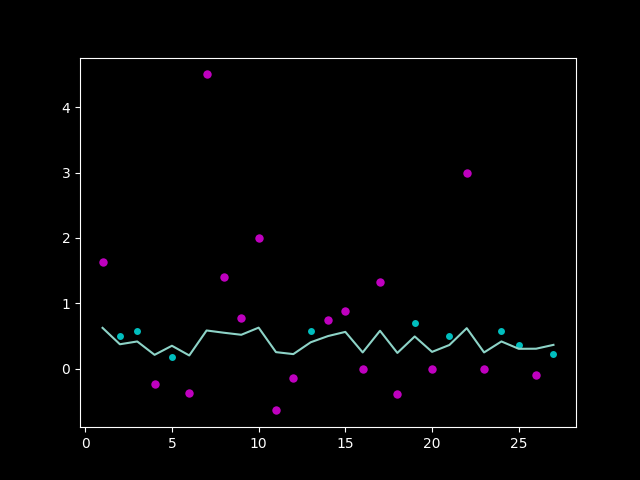

In [15]:
cases = np.linspace(1,n_cases,n_cases)
fig,ax = plt.subplots(1,1)
sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
# Plot remaining data
plt.scatter(cases, per_change, label="data", zorder=2, c="c", edgecolors=(0, 0, 0))
# Plot support vectors
plt.scatter(
    cases[sv_ind],
    per_change[sv_ind],
    s=50,
    c="m",
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0))


plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X))),
plt.style.use('dark_background')
plt.show()

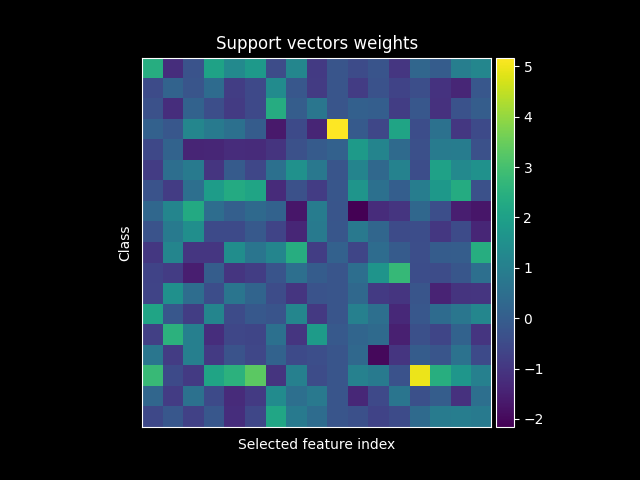

In [16]:
X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
fig,ax = plt.subplots(1,1)
im_svr = plt.imshow(X_SVR)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vectors weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svr,cax=cax,orientation='vertical')


In [17]:
clf_nsvr.best_estimator_.steps[0][1]._transform(X_t).shape

(1, 17)

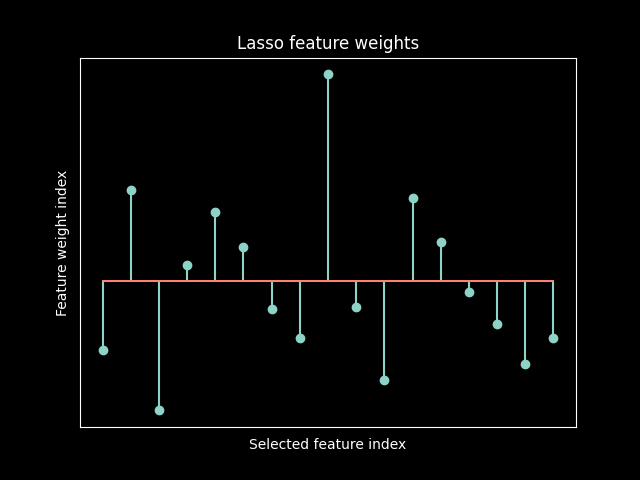

In [18]:
X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso.ravel())
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');